In [23]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
# 设置中文字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [24]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
device='cuda:0' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

划分训练集和测试集

In [25]:
df_suzhou=pd.read_excel("./data/宿州.xlsx")
df_suzhou['日期'] = pd.to_datetime(df_suzhou['日期'])
X1_suzhou=df_suzhou.drop(columns=['平均负荷','碳排放强度', '日期','机组'])
y1_suzhou=df_suzhou['碳排放强度']

df_maanshan=pd.read_excel("./data/马鞍山.xlsx")
df_maanshan['日期'] = pd.to_datetime(df_maanshan['日期'])

# out_file=open("D:\FlyFireF\Temp\GL.txt",'a')
# out_file.write("KF\n\n")
# df_maanshan = df_maanshan.sample(n=20,random_state=42)
X1 = df_maanshan.drop(columns=['平均负荷','碳排放强度','排汽温度', '日期'])
y1 = df_maanshan['碳排放强度']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [26]:
def plot_feature_importance(feature_importances):
    sorted_idx = np.argsort(feature_importances)  # 获取按重要性排序的索引
    sorted_feature_names = np.array(X1.columns)[sorted_idx]  # 排序后的特征名
    sorted_feature_importances = feature_importances[sorted_idx]  # 排序后的特征重要性
    sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性
    # 可视化特征重要性和正反相关性
    plt.figure(figsize=(10, 8))
    bars = plt.barh(sorted_feature_names, sorted_feature_importances,height = 0.6,color=np.where(sorted_correlations > 0, '#CA7373', '#4874CB'))
    # 设置y轴标签的字体粗细
    plt.yticks(fontsize=13, fontweight='bold')
    plt.xticks(fontsize=13, fontweight='bold')
    plt.xlabel("特征重要性", fontsize=13, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

In [27]:
def plot_line(pred):
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines  # 导入 mlines
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
    # 绘制test data预测值和真实值
    plt.figure(figsize=(9, 5))
    plt.plot(pred, label='预测值', linewidth=1,color = "#4874CB")       # 添加预测值的标签
    plt.plot(y1_test.values, label='实际值', linewidth=1, color='#CA7373')  # 添加真实值的标签
    # 绘制test data的预测值和真实值
    plt.scatter(range(len(pred)), pred, label='预测值',  alpha=0.7,marker= "X",color = "#4874CB")  # 绘制预测值的散点图
    plt.scatter(range(len(y1_test.values)), y1_test.values, label='实际值', alpha=0.7, color='#CA7373')  # 绘制真实值的散点图
    # 创建自定义的图例（线+点）
    line1 = mlines.Line2D([], [], color="#4874CB", marker="X", markersize=6, label="预测值")
    line2 = mlines.Line2D([], [], color="#CA7373", marker="o", markersize=6, label="实际值")

    # 显示图例
    plt.legend(handles=[line1, line2], fontsize=12.5)
    plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
    plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')

    # 显示图表
    plt.tight_layout()  # 调整布局，确保所有元素不重叠
    # plt.savefig("rf1.png",dpi=500,bbox_inches='tight')
    plt.show()

In [28]:
def plot_compare_line(pred,r2):
    # 计算线性回归拟合系数
    z = np.polyfit(y1_test, pred, 1)  # 线性拟合
    p = np.poly1d(z)  # 得到拟合的多项式函数
    # 计算拟合值
    y_fit = p(y1_test)
    # 计算残差
    residuals = pred - y_fit
    # 计算标准误差
    std_err = np.std(residuals)
    # 计算95%置信区间
    confidence_interval = 1.96 * std_err  # 95%置信区间对应的倍数是1.96
    # 使用 pandas DataFrame 排序
    data = pd.DataFrame({'y_test': y1_test, 'y_pred': pred, 'y_fit': y_fit})
    # 按 'y_test' 升序排序
    data_sorted = data.sort_values(by='y_test')
    # 提取排序后的值
    sorted_y_test = data_sorted['y_test'].values
    sorted_y_pred = data_sorted['y_pred'].values
    sorted_y_fit = data_sorted['y_fit'].values
    # 绘制散点图，x轴为实际值，y轴为预测值
    plt.scatter(sorted_y_test, sorted_y_pred, color='blue', alpha=0.6, edgecolor='k', label='Data point')
    # 绘制拟合线
    plt.plot(sorted_y_test, sorted_y_fit, color='orange', alpha=0.6, label=f"Fit line\n$R^2$ = {r2:.2f}")
    # 绘制95%置信区间阴影区域
    plt.fill_between(sorted_y_test, sorted_y_fit - confidence_interval, sorted_y_fit + confidence_interval, color='orange', alpha=0.2, label='95% Confidence interval')
    # 添加y=x的参考线，用于比较预测值与实际值的吻合度
    max_val = max(sorted_y_test.max(), sorted_y_pred.max())  # 找到最大值，确保参考线绘制完整
    min_val = min(sorted_y_test.min(), sorted_y_pred.min())  # 找到最小值
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')  # 画出y=x的对角线
    # 图表标题和标签
    plt.title("Comparison of model predictions with real values", fontsize=14)
    plt.xlabel("Real values of CEI / (g/kWh)", fontsize=14)
    plt.ylabel("Predictions of CEI / (g/kWh)", fontsize=14)
    # 显示图例
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

1.SVM

In [29]:
# 创建并训练SVR模型
svr_model1 = SVR(gamma=0.0059,C=1200,epsilon=0.00)
svr_model1.fit(X1_suzhou, y1_suzhou)
# 提取嫁接特征
svm_y_pred_AonB = svr_model1.predict(X1_train)
svm_y_pred_AonB_as_test = svr_model1.predict(X1_test)
# print(X1_train)
# print(svm_y_pred_AonB)
# 拼接特征
XB_with_graft=np.hstack((X1_train,pd.DataFrame({'AonB':svm_y_pred_AonB})))
XB_with_graft_as_test=np.hstack((X1_test,pd.DataFrame({'AonB':svm_y_pred_AonB_as_test})))
# 训练新模型
svr_model2 = SVR(gamma=0.0062,C=1600,epsilon=0.00)
svr_model2.fit(XB_with_graft,y1_train)
# 预测
svm_y_pred = svr_model2.predict(XB_with_graft_as_test)
# 评估模型
svm_mse = mean_squared_error(y1_test, svm_y_pred)
svm_rmse = np.sqrt(svm_mse)
svm_mae = mean_absolute_error(y1_test, svm_y_pred)
svm_mape = mean_absolute_percentage_error(y1_test, svm_y_pred)
svm_r2 = r2_score(y1_test, svm_y_pred)

print(f"svm_MSE: {svm_mse:.6f}")
print(f"svm_RMSE: {svm_rmse:.6f}")
print(f"svm_MAE: {svm_mae:.6f}")
print(f"svm_MAPE: {svm_mape*100:.6f}")
print(f"svm_R Square: {svm_r2:.6f}")
# out_file.write(f"svm_RMSE,{svm_rmse:.6f}\nsvm_MAE,{svm_mae:.6f}\nsvm_MAPE,{svm_mape*100:.6f}\nsvm_R Square,{svm_r2:.6f}\n\n")

svm_MSE: 13665.118234
svm_RMSE: 116.897897
svm_MAE: 89.767233
svm_MAPE: 16.313969
svm_R Square: 0.584563


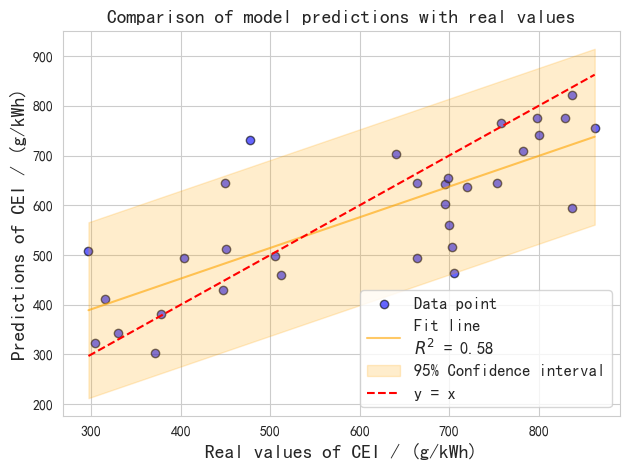

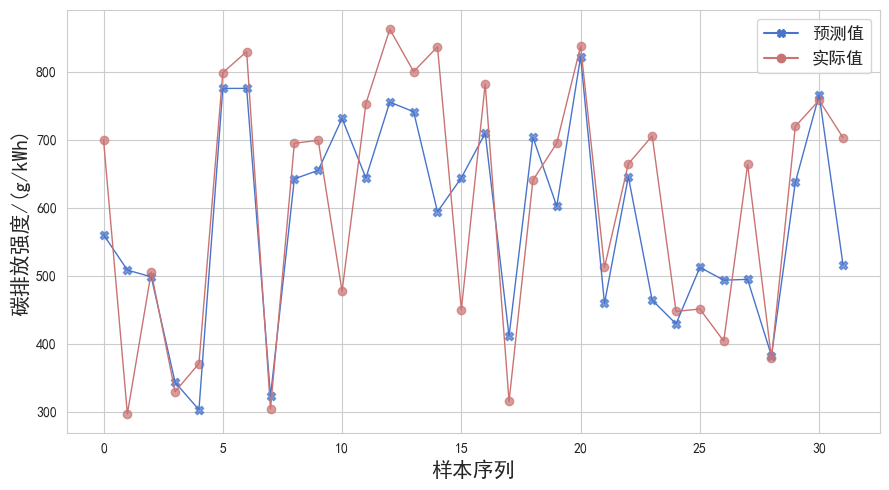

In [30]:
# plot_feature_importance(np.abs(svr_model.coef_).flatten())
plot_compare_line(svm_y_pred,svm_r2)
plot_line(svm_y_pred)

2.XGB

In [31]:
from xgboost import XGBRegressor
# 初始化XGBoost回归器
xgb_model1 = XGBRegressor(
    n_estimators=90,        # 树的数量
    max_depth=5,             # 树的最大深度
    learning_rate=0.08,       # 学习率
    subsample=0.84,           # 每棵树使用的样本比例
    colsample_bytree=0.8,    # 每棵树使用的特征比例
    random_state=42
)
# 训练模型
xgb_model1.fit(X1_suzhou, y1_suzhou)
# 提取嫁接特征
xgb_y_pred_AonB = xgb_model1.predict(X1_train)
xgb_y_pred_AonB_as_test = xgb_model1.predict(X1_test)
# 拼接特征
XB_with_graft=np.hstack((X1_train,pd.DataFrame({'AonB':xgb_y_pred_AonB})))
XB_with_graft_as_test=np.hstack((X1_test,pd.DataFrame({'AonB':xgb_y_pred_AonB_as_test})))
# 训练新模型
xgb_model2 = XGBRegressor(
    n_estimators=90,        # 树的数量
    max_depth=5,             # 树的最大深度
    learning_rate=0.09,       # 学习率
    subsample=0.84,           # 每棵树使用的样本比例
    colsample_bytree=0.8,    # 每棵树使用的特征比例
    random_state=42
)
xgb_model2.fit(XB_with_graft,y1_train)
# 预测
xgb_y_pred = xgb_model2.predict(XB_with_graft_as_test)
# 评估模型
xgb_mse = mean_squared_error(y1_test, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y1_test, xgb_y_pred)
xgb_mape = mean_absolute_percentage_error(y1_test, xgb_y_pred)
xgb_r2 = r2_score(y1_test, xgb_y_pred)

print(f"xgb_MSE: {xgb_mse:.6f}")
print(f"xgb_RMSE: {xgb_rmse:.6f}")
print(f"xgb_MAE: {xgb_mae:.6f}")
print(f"xgb_MAPE: {xgb_mape*100:.6f}")
print(f"xgb_R Square: {xgb_r2:.6f}")
# out_file.write(f"xgb_RMSE,{xgb_rmse:.6f}\nxgb_MAE,{xgb_mae:.6f}\nxgb_MAPE,{xgb_mape*100:.6f}\nxgb_R Square,{xgb_r2:.6f}\n\n")

xgb_MSE: 15062.082519
xgb_RMSE: 122.727676
xgb_MAE: 101.424573
xgb_MAPE: 18.399702
xgb_R Square: 0.542094


C:\Users\97112\AppData\Local\Temp\ipykernel_34668\2491693706.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性


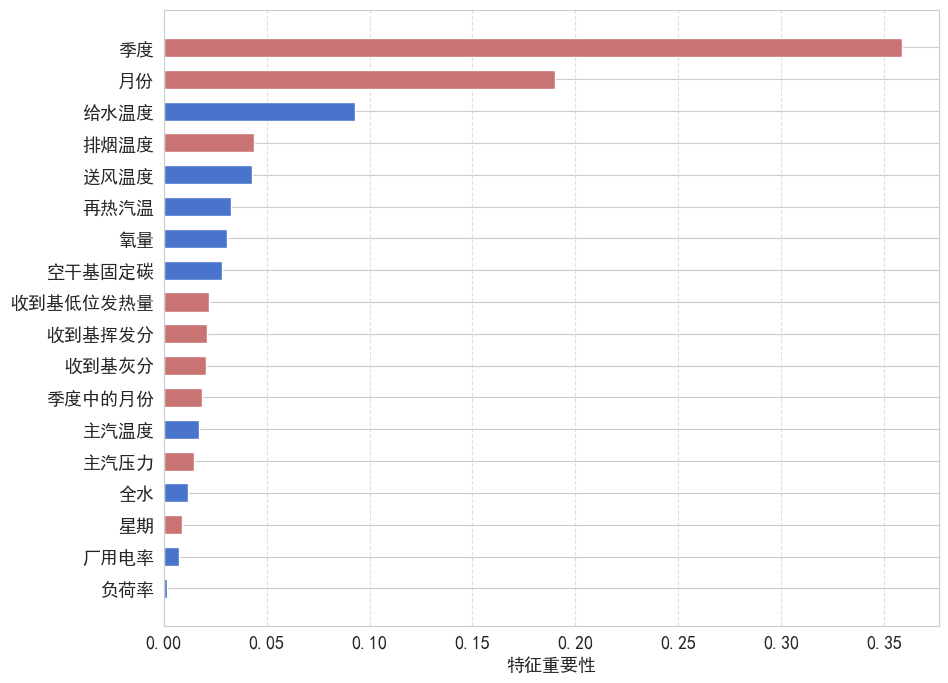

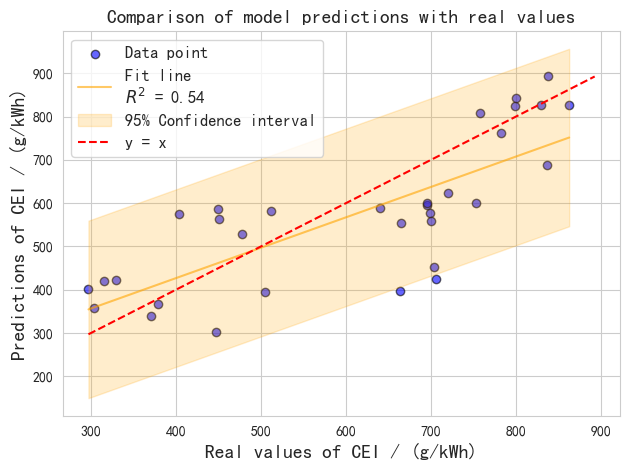

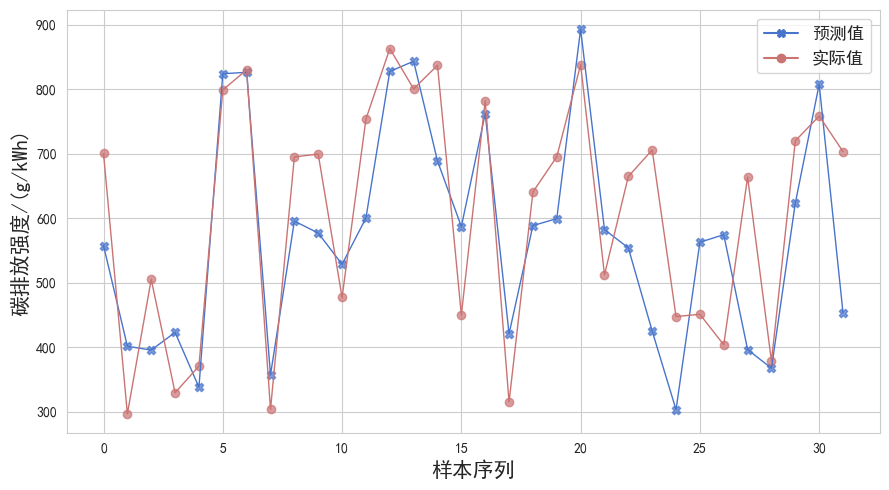

In [32]:
plot_feature_importance(xgb_model2.feature_importances_[:-1])
plot_compare_line(xgb_y_pred,xgb_r2)
plot_line(xgb_y_pred)

In [33]:
X1.columns

Index(['季度', '季度中的月份', '月份', '星期', '主汽温度', '主汽压力', '氧量', '排烟温度', '送风温度',
       '再热汽温', '给水温度', '全水', '收到基灰分', '收到基挥发分', '空干基固定碳', '收到基低位发热量', '厂用电率',
       '负荷率'],
      dtype='object')

In [34]:
feature_names=list(X1.columns)
feature_names.append('AonB')
feature_names=np.array(feature_names)
feature_names

array(['季度', '季度中的月份', '月份', '星期', '主汽温度', '主汽压力', '氧量', '排烟温度', '送风温度',
       '再热汽温', '给水温度', '全水', '收到基灰分', '收到基挥发分', '空干基固定碳', '收到基低位发热量',
       '厂用电率', '负荷率', 'AonB'], dtype='<U8')

In [35]:
df_with_graft=pd.DataFrame(XB_with_graft,columns=feature_names)

In [36]:
def pianYiLai(f1,f2,s1,s2,model):
    from sklearn.inspection import PartialDependenceDisplay
    import warnings
    warnings.filterwarnings("ignore")
    t2_features3 = [f1, f2,(f1,f2)]
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 生成双向部分依赖图
    disp = PartialDependenceDisplay.from_estimator(model, df_with_graft[0:300], t2_features3)
    disp.axes_.ravel()[0].set_ylabel('偏依赖量/(g/kWh)', fontsize=13, fontweight='bold')
    disp.axes_.ravel()[2].set_ylabel(s2, fontsize=13, fontweight='bold')
    disp.axes_.ravel()[0].set_xlabel(s1, fontsize=13, fontweight='bold')
    disp.axes_.ravel()[1].set_xlabel(s2, fontsize=13, fontweight='bold')
    disp.axes_.ravel()[2].set_xlabel(s1, fontsize=13, fontweight='bold')
    plt.subplots_adjust(wspace=0.7)
    #plt.savefig('partial_dependence_plot3.png', dpi=1000, bbox_inches='tight')
    plt.show()

In [37]:
# pianYiLai('负荷率','再热汽温','负荷率平均值(%)','再热汽温(°C)',xgb_model2)

In [38]:
'''pianYiLai('负荷率','送风温度','LR(%)','AST(°C)',xgb_model2)
pianYiLai('负荷率','排烟温度','负荷率平均值(%)','排烟温度/°C',xgb_model2)
pianYiLai('负荷率','氧量','负荷率平均值(%)','氧量(%)',xgb_model2)
pianYiLai('负荷率','全水','负荷率平均值(%)','全水(%)',xgb_model2)
pianYiLai('负荷率','主汽压力','负荷率平均值(%)','主汽压力(Pa)',xgb_model2)'''

"pianYiLai('负荷率','送风温度','LR(%)','AST(°C)',xgb_model2)\npianYiLai('负荷率','排烟温度','负荷率平均值(%)','排烟温度/°C',xgb_model2)\npianYiLai('负荷率','氧量','负荷率平均值(%)','氧量(%)',xgb_model2)\npianYiLai('负荷率','全水','负荷率平均值(%)','全水(%)',xgb_model2)\npianYiLai('负荷率','主汽压力','负荷率平均值(%)','主汽压力(Pa)',xgb_model2)"

3.RF

In [39]:
correlation_matrix = df_maanshan.drop(columns=['排汽温度', '日期']).corr()
from sklearn.ensemble import RandomForestRegressor
rf_model1 = RandomForestRegressor(n_jobs=28,max_depth=6,n_estimators=118,random_state=42)
rf_model1.fit(X1_suzhou, y1_suzhou)
# 提取嫁接特征
rf_y_pred_AonB = rf_model1.predict(X1_train)
rf_y_pred_AonB_as_test = rf_model1.predict(X1_test)
# 拼接特征
XB_with_graft=np.hstack((X1_train,pd.DataFrame({'AonB':rf_y_pred_AonB})))
XB_with_graft_as_test=np.hstack((X1_test,pd.DataFrame({'AonB':rf_y_pred_AonB_as_test})))
# 训练新模型
rf_model2 = RandomForestRegressor(n_jobs=28,max_depth=6,n_estimators=130,random_state=42)
rf_model2.fit(XB_with_graft,y1_train)
# 预测
rf_y_pred = rf_model2.predict(XB_with_graft_as_test)
# 评估模型
rf_mse = mean_squared_error(y1_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y1_test, rf_y_pred)
rf_mape = mean_absolute_percentage_error(y1_test, rf_y_pred)
rf_r2 = r2_score(y1_test, rf_y_pred)

print(f"rf_MSE: {rf_mse:.6f}")
print(f"rf_RMSE: {rf_rmse:.6f}")
print(f"rf_MAE: {rf_mae:.6f}")
print(f"rf_MAPE: {rf_mape*100:.6f}")
print(f"rf_R Square: {rf_r2:.6f}")
# out_file.write(f"rf_RMSE,{rf_rmse:.6f}\nrf_MAE,{rf_mae:.6f}\nrf_MAPE,{rf_mape*100:.6f}\nrf_R Square,{rf_r2:.6f}\n\n")

rf_MSE: 12916.874743
rf_RMSE: 113.652430
rf_MAE: 90.768645
rf_MAPE: 16.321824
rf_R Square: 0.607311


In [40]:
'''pianYiLai('负荷率','再热汽温','负荷率平均值(%)','再热汽温(°C)',rf_model2)
pianYiLai('负荷率','送风温度','LR(%)','AST(°C)',rf_model2)
pianYiLai('负荷率','排烟温度','负荷率平均值(%)','排烟温度/°C',rf_model2)
pianYiLai('负荷率','氧量','负荷率平均值(%)','氧量(%)',rf_model2)
pianYiLai('负荷率','全水','负荷率平均值(%)','全水(%)',rf_model2)
pianYiLai('负荷率','主汽压力','负荷率平均值(%)','主汽压力(Pa)',rf_model2)'''

"pianYiLai('负荷率','再热汽温','负荷率平均值(%)','再热汽温(°C)',rf_model2)\npianYiLai('负荷率','送风温度','LR(%)','AST(°C)',rf_model2)\npianYiLai('负荷率','排烟温度','负荷率平均值(%)','排烟温度/°C',rf_model2)\npianYiLai('负荷率','氧量','负荷率平均值(%)','氧量(%)',rf_model2)\npianYiLai('负荷率','全水','负荷率平均值(%)','全水(%)',rf_model2)\npianYiLai('负荷率','主汽压力','负荷率平均值(%)','主汽压力(Pa)',rf_model2)"

C:\Users\97112\AppData\Local\Temp\ipykernel_34668\2491693706.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性


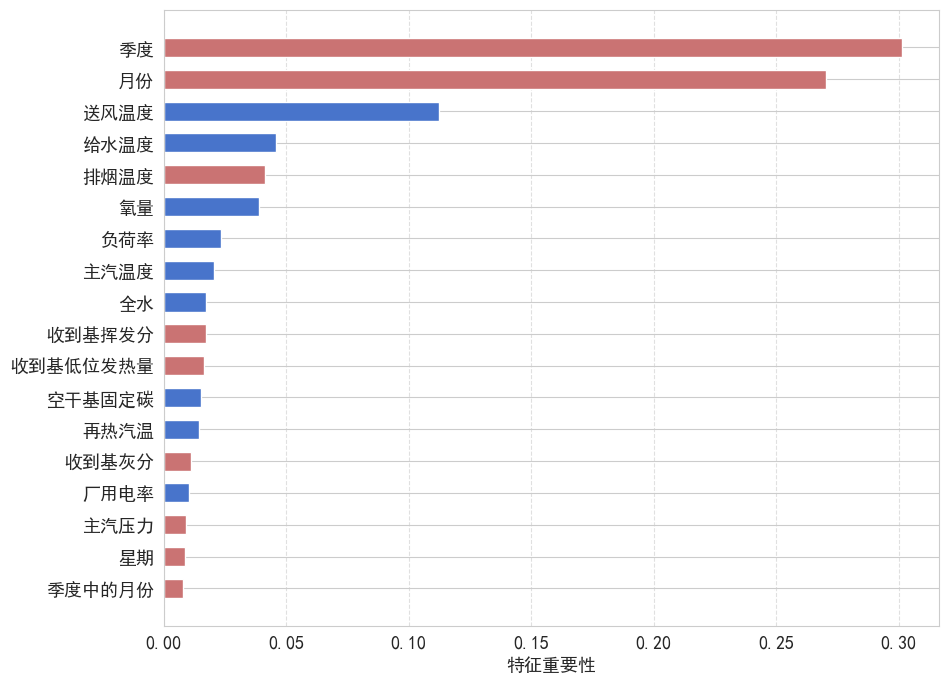

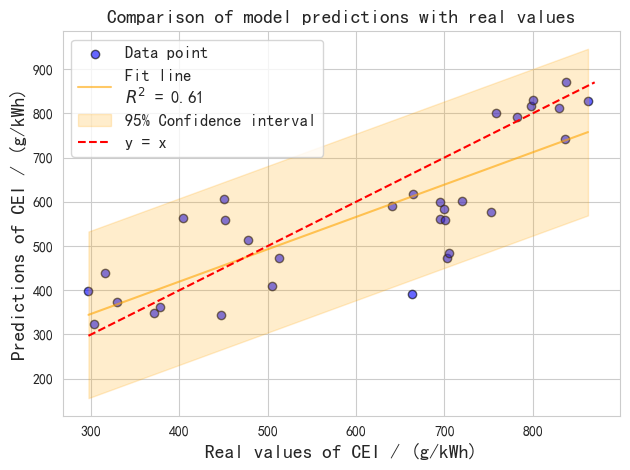

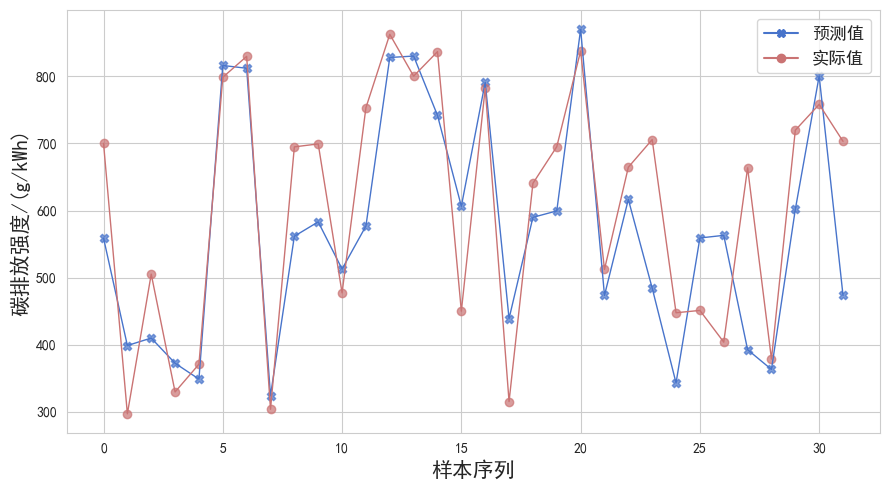

In [41]:
plot_feature_importance(rf_model2.feature_importances_[:-1])
plot_compare_line(rf_y_pred,rf_r2)
plot_line(rf_y_pred)

4.LR

In [42]:
from sklearn.linear_model import LinearRegression
# 创建线性回归模型
lr_model = LinearRegression()
lr_model.fit(X1_suzhou, y1_suzhou)
# 提取嫁接特征
lr_y_pred_AonB = lr_model.predict(X1_train)
lr_y_pred_AonB_as_test = lr_model.predict(X1_test)
# 拼接特征
XB_with_graft=np.hstack((X1_train,pd.DataFrame({'AonB':lr_y_pred_AonB})))
XB_with_graft_as_test=np.hstack((X1_test,pd.DataFrame({'AonB':lr_y_pred_AonB_as_test})))
# 训练新模型
lr_model.fit(XB_with_graft,y1_train)
# 预测
lr_y_pred = lr_model.predict(XB_with_graft_as_test)
# 评估模型
lr_mse = mean_squared_error(y1_test, lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y1_test, lr_y_pred)
lr_mape = mean_absolute_percentage_error(y1_test, lr_y_pred)
lr_r2 = r2_score(y1_test, lr_y_pred)

print(f"lr_MSE: {lr_mse:.6f}")
print(f"lr_RMSE: {lr_rmse:.6f}")
print(f"lr_MAE: {lr_mae:.6f}")
print(f"lr_MAPE: {lr_mape*100:.6f}")
print(f"lr_R Square: {lr_r2:.6f}")
# out_file.write(f"lr_RMSE,{lr_rmse:.6f}\nlr_MAE,{lr_mae:.6f}\nlr_MAPE,{lr_mape*100:.6f}\nlr_R Square,{lr_r2:.6f}\n\n")

lr_MSE: 15756.495000
lr_RMSE: 125.524878
lr_MAE: 102.302248
lr_MAPE: 19.835896
lr_R Square: 0.520983


C:\Users\97112\AppData\Local\Temp\ipykernel_34668\2491693706.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = df_maanshan.corr()['碳排放强度'].drop('碳排放强度')[sorted_idx]  # 排序后的相关性


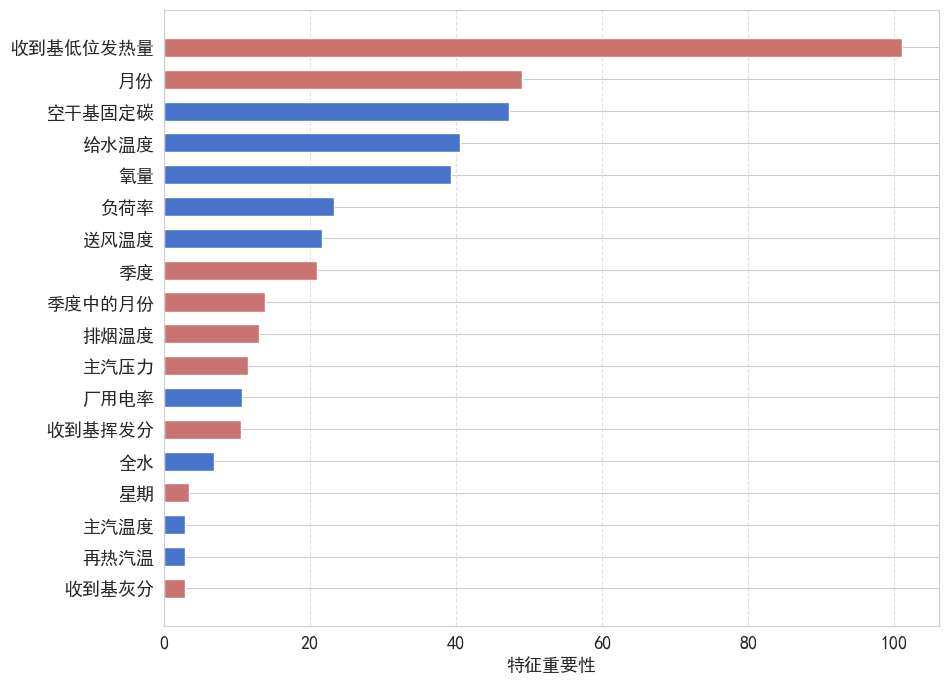

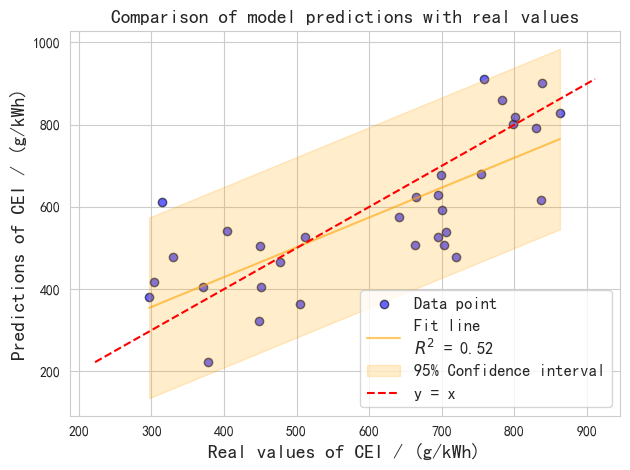

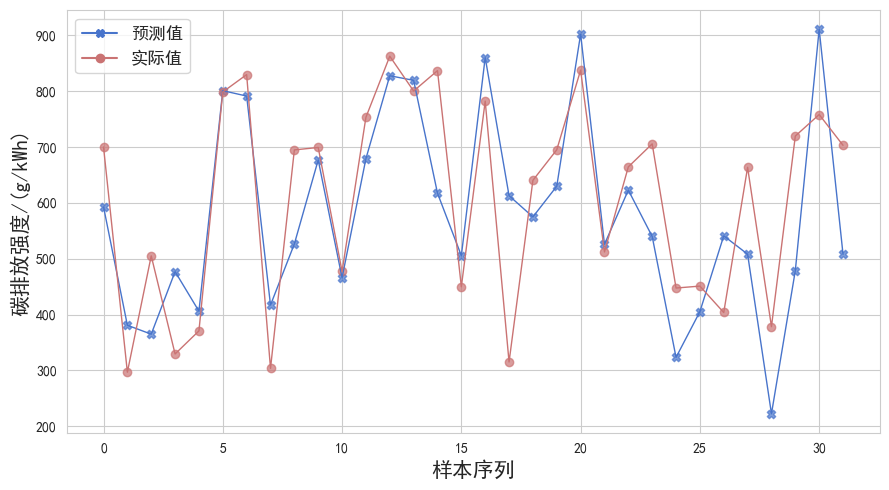

In [43]:
plot_feature_importance(np.abs(lr_model.coef_).flatten()[:-1])
plot_compare_line(lr_y_pred,lr_r2)
plot_line(lr_y_pred)

5.DNN

In [44]:
from sklearn.model_selection import KFold

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# for train_index, val_index in kf.split(X1):
#     X1_train = X1.iloc[train_index]
#     X1_test = X1.iloc[val_index]
#     y1_train = y1.iloc[train_index]
#     y1_test = y1.iloc[val_index]

device='cuda:0' if torch.cuda.is_available() else 'cpu'
set_seed(42)
# 数据标准化
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
X1_suzhou_scaled=scaler1.fit_transform(X1_suzhou)
y1_suzhou_scaled=scaler1.fit_transform(y1_suzhou.to_frame())
X1_train_scaled=scaler2.fit_transform(X1_train)
y1_train_scaled=scaler2.fit_transform(y1_train.to_frame())
X1_test_scaled=scaler3.fit_transform(X1_test)
y1_test_scaled=scaler3.fit_transform(y1_test.to_frame())
# 转为Tensor
X1_suzhou_tensor=torch.FloatTensor(X1_suzhou_scaled).to(device)
y1_suzhou_tensor=torch.FloatTensor(y1_suzhou_scaled).view(-1,1).to(device)
X1_train_tensor=torch.FloatTensor(X1_train_scaled).to(device)
y1_train_tensor=torch.FloatTensor(y1_train_scaled).view(-1,1).to(device)
X1_test_tensor=torch.FloatTensor(X1_test_scaled).to(device)
y1_test_tensor=torch.FloatTensor(y1_test_scaled).view(-1,1).to(device)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # 第一个隐藏层
        self.fc2 = nn.Linear(64, 32)          # 第二个隐藏层
        self.fc3 = nn.Linear(32, 1)           # 输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# 1. 训练基础模型 Model A
# 初始化模型
input_size = X1_suzhou.shape[1]
model_a = SimpleNN(input_size).to(device)
# 定义损失函数和优化器
criterion = nn.MSELoss().to(device)  # 均方误差损失
optimizer = optim.SGD(model_a.parameters(), lr=0.16)
# 训练模型
num_epochs = 5100
for epoch in range(num_epochs):
    model_a.train()  # 设定训练模式
    optimizer.zero_grad()  # 梯度清零
    outputs = model_a(X1_suzhou_tensor)  # 前向传播
    loss = criterion(outputs, y1_suzhou_tensor)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 2. 提取嫁接特征
model_a.eval()  # 切换到评估模式
with torch.no_grad():
    dnn_y_pred_AonB = model_a(X1_train_tensor)  # 预测
    dnn_y_pred_AonB_as_test = model_a(X1_test_tensor)
# 拼接特征
XB_with_graft=np.hstack((X1_train_scaled,pd.DataFrame({'AonB':dnn_y_pred_AonB.cpu().numpy().flatten()})))
XB_with_graft_as_test=np.hstack((X1_test_scaled,pd.DataFrame({'AonB':dnn_y_pred_AonB_as_test.cpu().numpy().flatten()})))
XB_with_graft_tensor=torch.FloatTensor(XB_with_graft).to(device)
XB_with_graft_as_test_tensor=torch.FloatTensor(XB_with_graft_as_test).to(device)
# 训练新模型
# 初始化模型
input_size_b = XB_with_graft.shape[1]
model_b = SimpleNN(input_size_b).to(device)
# 定义损失函数和优化器
criterion = nn.MSELoss().to(device)  # 均方误差损失
optimizer = optim.SGD(model_b.parameters(), lr=0.05)
# 训练模型b
num_epochs = 2000
for epoch in range(num_epochs):
    model_b.train()  # 设定训练模式
    optimizer.zero_grad()  # 梯度清零
    outputs = model_b(XB_with_graft_tensor)  # 前向传播
    loss = criterion(outputs, y1_train_tensor)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
# 预测
model_b.eval()  # 切换到评估模式
with torch.no_grad():
    dnn_y_pred_B = model_b(XB_with_graft_as_test_tensor)  # 预测
# 评估模型
dnn_y_pred_B=dnn_y_pred_B.cpu().numpy().flatten()
dnn_y_pred_B=scaler3.inverse_transform(pd.DataFrame({'pred':dnn_y_pred_B}))

dnn_mse = mean_squared_error(y1_test, dnn_y_pred_B)
dnn_rmse = np.sqrt(dnn_mse)
dnn_mae = mean_absolute_error(y1_test, dnn_y_pred_B)
dnn_mape = mean_absolute_percentage_error(y1_test, dnn_y_pred_B)
dnn_r2 = r2_score(y1_test, dnn_y_pred_B)

print(f"dnn_MSE: {dnn_mse:.6f}")
print(f"dnn_RMSE: {dnn_rmse:.6f}")
print(f"dnn_MAE: {dnn_mae:.6f}")
print(f"dnn_MAPE: {dnn_mape*100:.6f}")
print(f"dnn_R Square: {dnn_r2:.6f}")
# out_file.write(f"dnn_RMSE,{dnn_rmse:.6f}\ndnn_MAE,{dnn_mae:.6f}\ndnn_MAPE,{dnn_mape*100:.6f}\ndnn_R Square,{dnn_r2:.6f}\n\n")

Epoch [1000/5100], Loss: 0.0060
Epoch [2000/5100], Loss: 0.0042
Epoch [3000/5100], Loss: 0.0033
Epoch [4000/5100], Loss: 0.0029
Epoch [5000/5100], Loss: 0.0024
Epoch [1000/2000], Loss: 0.0228
Epoch [2000/2000], Loss: 0.0148
dnn_MSE: 11662.391002
dnn_RMSE: 107.992551
dnn_MAE: 89.391194
dnn_MAPE: 18.104969
dnn_R Square: 0.645449


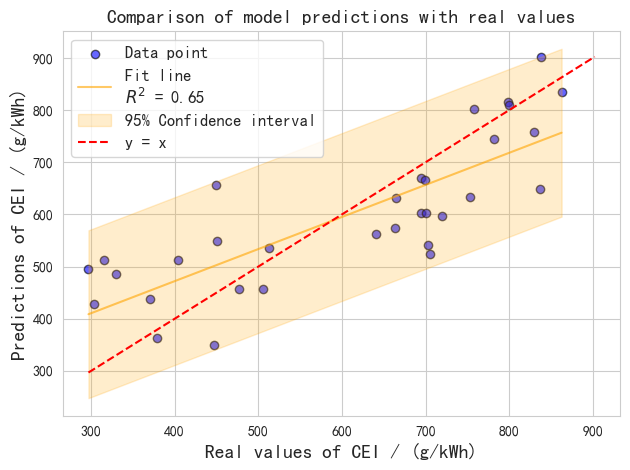

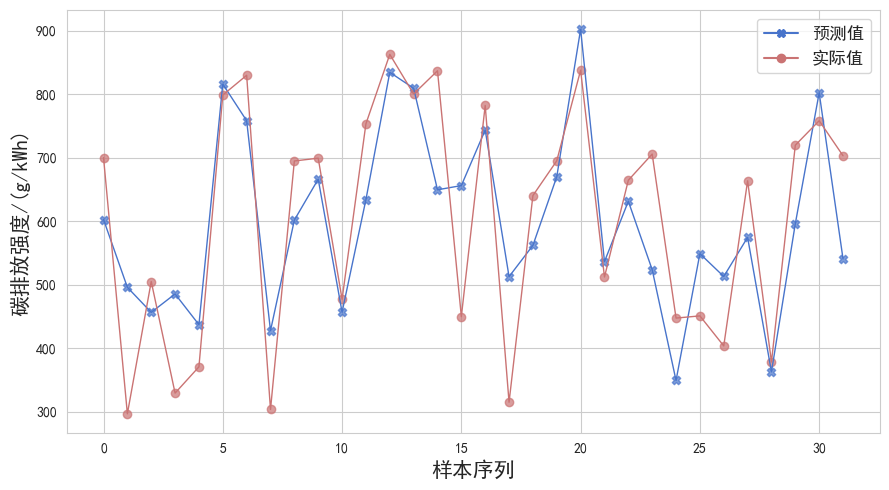

In [45]:
# plot_feature_importance(model.)
plot_compare_line(dnn_y_pred_B.T[0],dnn_r2)
plot_line(dnn_y_pred_B)

In [1340]:
df_to_pred=pd.read_excel("./data/马鞍山2号清洗2024.xlsx")
X1_pred = df_to_pred.drop(columns=['平均负荷','排汽温度', '日期'])
scaler4 = MinMaxScaler()
X1_pred_scaled=scaler4.fit_transform(X1_pred)
X1_pred_tensor=torch.FloatTensor(X1_pred_scaled).to(device)
y1_scaled=scaler4.fit_transform(y1.to_frame())

model_a.eval()  # 切换到评估模式
with torch.no_grad():
    dnn_y_pred_AonB_final = model_a(X1_pred_tensor)  # 预测

X_pred_with_graft=np.hstack((X1_pred_scaled,pd.DataFrame({'AonB':dnn_y_pred_AonB_final.cpu().numpy().flatten()})))
X_pred_with_graft_tensor=torch.FloatTensor(X_pred_with_graft).to(device)

model_b.eval()  # 切换到评估模式
with torch.no_grad():
    dnn_y_pred_final = model_b(X_pred_with_graft_tensor)

dnn_y_pred_final=dnn_y_pred_final.cpu().numpy().flatten()
dnn_y_pred_final=scaler4.inverse_transform(pd.DataFrame({'pred':dnn_y_pred_final}))

In [1341]:
pred_sort=np.sort(dnn_y_pred_final,axis=0)
pred_sort

array([[325.26025],
       [328.14502],
       [336.52567],
       [339.1392 ],
       [339.75275],
       [355.0049 ],
       [366.58496],
       [370.2652 ],
       [371.06647],
       [374.4041 ],
       [376.26245],
       [377.5969 ],
       [378.1426 ],
       [380.1936 ],
       [384.08923],
       [389.9526 ],
       [390.89194],
       [391.5269 ],
       [394.5308 ],
       [394.6788 ],
       [395.0352 ],
       [395.15182],
       [396.8422 ],
       [399.36926],
       [401.5262 ],
       [401.91135],
       [402.0817 ],
       [402.63217],
       [403.81094],
       [404.0914 ],
       [405.53888],
       [406.38177],
       [407.66183],
       [409.77103],
       [410.32208],
       [410.85867],
       [415.35922],
       [417.21072],
       [418.91943],
       [419.76776],
       [420.19162],
       [422.57788],
       [422.95322],
       [424.19565],
       [425.0998 ],
       [425.37308],
       [425.8184 ],
       [427.77777],
       [427.78983],
       [427.93228],


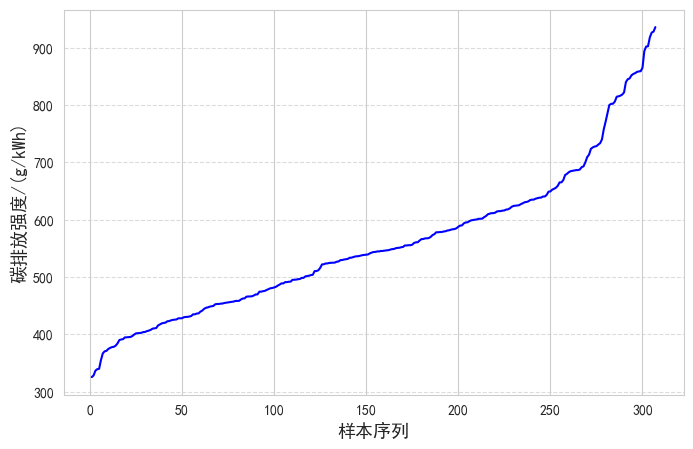

In [1342]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1,len(pred_sort)+1)), pred_sort.T[0], color='blue')
plt.xlabel('样本序列',fontsize=13)
plt.ylabel('碳排放强度/(g/kWh)',fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

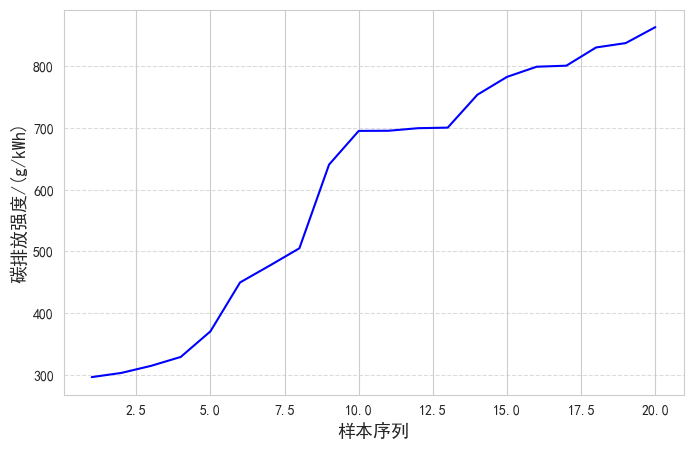

In [1343]:
y1_sort=np.sort(y1,axis=0)
plt.figure(figsize=(8, 5))
plt.plot(list(range(1,len(y1_sort)+1)), y1_sort.T, color='blue')
plt.xlabel('样本序列',fontsize=13)
plt.ylabel('碳排放强度/(g/kWh)',fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [1344]:
pd.DataFrame(dnn_y_pred_final).describe()

,0
count,307.000000
mean,557.342651
std,130.665283
min,325.260254
25%,456.794769
50%,543.428894
75%,623.976349
max,935.691406


In [1345]:
pd.DataFrame(y1).describe()

,碳排放强度
count,20.000000
mean,607.120358
std,203.389952
min,296.893344
25%,430.159838
50%,695.034892
75%,786.371553
max,862.697730


In [1346]:
feature_names=list(X1_pred.columns)
feature_names.append('AonB')
feature_names=np.array(feature_names)
feature_names

array(['季度', '季度中的月份', '月份', '星期', '主汽温度', '主汽压力', '氧量', '排烟温度', '送风温度',
       '再热汽温', '给水温度', '全水', '收到基灰分', '收到基挥发分', '空干基固定碳', '收到基低位发热量',
       '厂用电率', '负荷率', 'AonB'], dtype='<U8')

In [1347]:
'''import shap
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
# Use the trained SVR model to create an explainer
explainer = shap.DeepExplainer(model_b, XB_with_graft_tensor)
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(XB_with_graft_as_test_tensor.cpu(),check_additivity=False)
# Visualize feature importance using SHAP
shap.summary_plot(np.squeeze(shap_values), XB_with_graft_as_test_tensor.cpu(), feature_names=feature_names)'''

"import shap\nplt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei\nplt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题\n# Use the trained SVR model to create an explainer\nexplainer = shap.DeepExplainer(model_b, XB_with_graft_tensor)\n# Calculate SHAP values for the test set\nshap_values = explainer.shap_values(XB_with_graft_as_test_tensor.cpu(),check_additivity=False)\n# Visualize feature importance using SHAP\nshap.summary_plot(np.squeeze(shap_values), XB_with_graft_as_test_tensor.cpu(), feature_names=feature_names)"

In [1348]:
# np.squeeze(shap_values)

array([[-1.04850270e-01, -8.40738416e-04, -3.88324931e-02,
         3.90223637e-02, -5.14340634e-03,  4.66124602e-02,
        -7.66724646e-02,  7.76422620e-02,  8.94726664e-02,
        -9.73768458e-02, -5.01987636e-02,  1.26706855e-02,
         2.23165657e-02, -1.34488996e-02, -1.75204538e-02,
        -3.72254923e-02, -1.70445628e-02, -1.79883633e-02,
         2.53105257e-03],
       [ 2.71547765e-01, -2.36095097e-02,  7.98155144e-02,
         2.54208650e-02, -1.75770894e-02,  7.14948997e-02,
        -1.22610822e-01,  7.26658385e-03,  4.13185060e-02,
        -4.64997478e-02, -8.90023783e-02,  5.18883541e-02,
        -2.84641162e-02, -5.19209653e-02, -1.54120652e-02,
        -3.59079279e-02, -1.86655521e-02, -2.71670595e-02,
         2.29862519e-03],
       [-1.04850270e-01,  2.19280329e-02, -5.06972931e-02,
        -1.78211730e-03, -4.88851359e-03,  3.98424966e-03,
        -2.14899518e-02,  7.34822005e-02,  3.57061177e-02,
        -5.64288422e-02, -7.83375092e-03, -1.24525954e-03,
    

In [22]:
# out_file.flush()
# out_file.close()